<a href="https://colab.research.google.com/github/tariqshaban/disaster-classification-with-xai/blob/master/CNN%20Disaster%20Dataset%20with%20Explainable%20AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Dependencies

In [1]:
!pip install lime
!pip install colorama
!pip install opencv-python
!git clone https://github.com/samson6460/tf_keras_gradcamplusplus.git ./assets/tf_keras_gradcamplusplus
    
# Download assets from the GitHub repository
!apt install subversion
!svn checkout https://github.com/tariqshaban/disaster-classification-with-xai/trunk/assets
    
import os
import sys
import re
import random
import shutil
import cv2
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from colorama import Fore, Style
from PIL import Image
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Layer
from keras.models import Sequential
from keras.preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
from lime import lime_image
from skimage.segmentation import mark_boundaries
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications import VGG19
from tensorflow.keras.preprocessing import image
from glob import glob
from assets.tf_keras_gradcamplusplus.utils import preprocess_image
from assets.tf_keras_gradcamplusplus.gradcam import grad_cam, grad_cam_plus
from IPython.display import clear_output

plt.rcParams["figure.figsize"] = (15,8)

clear_output()
print(Fore.GREEN + u'\u2713 ' + 'Successfully downloaded dependencies.')    
print(Style.RESET_ALL)

✓ Successfully downloaded dependencies.



In [2]:
class IgnorePrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

# Global Variables

In [3]:
CLASSES=('infrastructure','land_slide','non_damage_buildings_street','non_damage_wildlife_forest','sea','urban_fire','water_disaster','wild_fire')

IMAGE_SHAPE_2D = (224, 224)
IMAGE_SHAPE_3D = (224, 224, 3)

SOURCE_DIRECTORY = './assets/disaster_data/'
TRAIN_DIRECTORY = './assets/refactored_data/train/'
VALID_DIRECTORY = './assets/refactored_data/valid/'
TEST_DIRECTORY = './assets/refactored_data/tests/'

EPOCHS = 50
# LEARNING_RATE = 0.1
LEARNING_RATE = 0.01
# LEARNING_RATE = 0.001

BASE_MODEL = ResNet50(weights='imagenet', include_top=False, input_shape=IMAGE_SHAPE_3D)
PREPROCESSING_METHOD = preprocessing_function=tf.keras.applications.resnet50.preprocess_input

# BASE_MODEL = InceptionV3(weights='imagenet', include_top=False, input_shape=IMAGE_SHAPE_3D)
# PREPROCESSING_METHOD = preprocessing_function=tf.keras.applications.inception_v3.preprocess_input

# BASE_MODEL = VGG19(weights='imagenet', include_top=False, input_shape=IMAGE_SHAPE_3D)
# PREPROCESSING_METHOD = preprocessing_function=tf.keras.applications.vgg19.preprocess_input

OPTIMIZER = tf.keras.optimizers.RMSprop(learning_rate=LEARNING_RATE)
# OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

# Helper Methods

#### Prime Dataset

In [4]:
def prime_dataset():
  # Get Data From GitHub Repository


  # Read Each Image With its Class Label
  images = []
  folders=CLASSES

  for folder in folders:
    t = folder
    x = !ls $SOURCE_DIRECTORY$t
    for i in x:
      
      for j in re.split(r'[-;,\t\s]\s*', i):
        if j == '':
          continue
        images.append({'Class':t,'Image':j})


  # Partition Images into Traning, Validation, and Testing
  for c in folders:
      os.makedirs(f'{TRAIN_DIRECTORY}{c}', exist_ok=True)    
      os.makedirs(f'{VALID_DIRECTORY}{c}', exist_ok=True)    
      os.makedirs(f'{TEST_DIRECTORY}{c}', exist_ok=True)

  sizeList = [520,456,533,572,546,514,546,514]
  counter=0
  for c in folders:
      for files in random.sample(glob(f'{SOURCE_DIRECTORY}{c}/*'), int(sizeList[counter]*.7)):
          shutil.copy(files, f'{TRAIN_DIRECTORY}{c}') 
            
      for files in random.sample(glob(f'{SOURCE_DIRECTORY}{c}/*'), int(sizeList[counter]*.2)):
          shutil.copy(files, f'{VALID_DIRECTORY}{c}')
      
      for files in random.sample(glob(f'{SOURCE_DIRECTORY}{c}/*'), int(sizeList[counter]*.1)):
          shutil.copy(files, f'{TEST_DIRECTORY}{c}')
      counter+=1

#### Build Model

In [5]:
def build_model(measure_performance:bool = True):
  train_batches = ImageDataGenerator(preprocessing_function=PREPROCESSING_METHOD).flow_from_directory(directory=TRAIN_DIRECTORY, target_size=IMAGE_SHAPE_2D, classes=CLASSES, batch_size=128)
  valid_batches = ImageDataGenerator(preprocessing_function=PREPROCESSING_METHOD).flow_from_directory(directory=VALID_DIRECTORY, target_size=IMAGE_SHAPE_2D, classes=CLASSES, batch_size=128, shuffle=False)
  test_batches =  ImageDataGenerator(preprocessing_function=PREPROCESSING_METHOD).flow_from_directory(directory=TEST_DIRECTORY, target_size=IMAGE_SHAPE_2D, classes=CLASSES, batch_size=128, shuffle=False)

  input_shape = IMAGE_SHAPE_3D
  nclass = 8
  epoch = EPOCHS
  base_model = BASE_MODEL
  base_model.trainable = False

  add_model = Sequential()
  add_model.add(base_model)
  add_model.add(Layer())
  add_model.add(GlobalAveragePooling2D())
  add_model.add(Dropout(0.5))
  add_model.add(Dense(nclass, activation='softmax'))

  model = add_model
  model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=LEARNING_RATE), loss='categorical_crossentropy', metrics=['accuracy'])
  es = EarlyStopping(monitor='val_loss', mode='auto', verbose=1 ,  patience = 10)


  fitted_model= model.fit(x=train_batches, validation_data=valid_batches, epochs=epoch, callbacks=[es])
  score, accuracy = model.evaluate(x=test_batches, batch_size=128)

  print(Fore.GREEN + u'\n\u2713 ' + f'Accuracy ==> {accuracy}')    

  if measure_performance:
    plt.plot(fitted_model.history['accuracy'])
    plt.plot(fitted_model.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    plt.plot(fitted_model.history['loss'])
    plt.plot(fitted_model.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    
    y_pred = model.predict(test_batches)
    
    ax = sns.heatmap(confusion_matrix(test_batches.classes, y_pred.argmax(axis=1)), annot=True, cmap='Blues', fmt='g')
    ax.set_title('Confusion Matrix')
    ax.set_xlabel('Predicted Values')
    ax.set_ylabel('Actual Values')
    ax.xaxis.set_ticklabels(CLASSES)
    ax.yaxis.set_ticklabels(CLASSES)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.show()
  
  return model

#### Predict Image Class

In [6]:
def predict_image_class(img, model):
  img = np.expand_dims(img, axis=0)
  print(Fore.GREEN + u'\n\u2713 ' + f'Model Output ==> {CLASSES[np.argmax(model.predict(img))]}')    
  print(Style.RESET_ALL)

#### Show Image

In [7]:
def show_image(img):
  img = Image.fromarray(img)  
  display(img)

#### URL to Image

In [8]:
def url_to_image(url):
  image_url = tf.keras.utils.get_file(origin=url)
  img = image.load_img(image_url, target_size=IMAGE_SHAPE_2D)
  img = np.expand_dims(img, axis=0)
  return np.vstack([img])[0]

#### Get Image

In [9]:
def path_to_image(image_name = None):
  if image_name is None:  
    images = []  
    for dirpath,_,filenames in os.walk(SOURCE_DIRECTORY):
      for f in filenames:
        images.append(os.path.abspath(os.path.join(dirpath, f)))
    image_name = random.choice(images)
  else:
    image_name = SOURCE_DIRECTORY + image_name
  img = Image.open(image_name)
  img = img.resize(IMAGE_SHAPE_2D)    
  img = np.expand_dims(img, axis=0)
  return np.vstack([img])[0]

#### Implement image preprocessing method

In [10]:
def image_preprocess(img):
  return PREPROCESSING_METHOD(img)

#### Implement Lime XAI

In [11]:
def explain_image_lime(img, model):
  # Temporarily disable output stream, preventing unnecesarry output
  with IgnorePrints():
      preprocessedImage = image_preprocess(img)

      explainer = lime_image.LimeImageExplainer()
      explanation = explainer.explain_instance(np.asanyarray(preprocessedImage).astype('double'), model.predict, top_labels=5, hide_color=0, num_samples=1000)

      temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
        
  return mark_boundaries(img, mask)
 

#### Implemnt Grad-CAM XAI

In [12]:
def show_imgwithheat(img_path, heatmap, alpha=0.4):
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = (heatmap*255).astype("uint8")
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * alpha + img
    superimposed_img = np.clip(superimposed_img, 0, 255).astype("uint8")
    superimposed_img = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)

    return superimposed_img

In [13]:
def explain_image_grad_cam(img, model):
  image_path = './assets/buffer.jpg'  

  Image.fromarray(img).save(image_path)
    
  img = preprocess_image(image_path, target_size=IMAGE_SHAPE_2D)
    
  heatmap = grad_cam(
    model, img,
    layer_name = model.layers[1].name,
  )
    
  img_arr = show_imgwithheat(image_path, heatmap)

  os.remove(image_path)
    
  return img_arr

#### Implemnt Grad-CAM++XAI

In [14]:
def explain_image_grad_cam_plus_plus(img, model):
  image_path = './assets/buffer.jpg'   

  Image.fromarray(img).save(image_path)
    
  img = preprocess_image(image_path, target_size=IMAGE_SHAPE_2D)

  heatmap = grad_cam_plus(
    model, img,
    layer_name = model.layers[1].name,
  )
    
  show_imgwithheat(image_path, heatmap)

  img_arr = show_imgwithheat(image_path, heatmap)

  os.remove(image_path)
    
  return img_arr

#### Plot XAI

In [15]:
def plot_XAI(img, model):
  plt.rcParams["figure.figsize"] = (10,10)
  fig, ax = plt.subplots(2,2)
  ax[0,0].imshow(img)
  ax[0,1].imshow(explain_image_lime(img, model))
  ax[1,0].imshow(explain_image_grad_cam(img, model))
  ax[1,1].imshow(explain_image_grad_cam_plus_plus(img, model))

  ax[0, 0].set_title("Original Image")
  ax[0, 1].set_title("LIME")
  ax[1, 0].set_title("Grad-CAM")
  ax[1, 1].set_title("Grad-CAM++")

  fig.tight_layout()
  plt.show()
  plt.rcParams["figure.figsize"] = (15,8)

# Methods Invocation

In [16]:
prime_dataset()

Found 4079 images belonging to 8 classes.
Found 2478 images belonging to 8 classes.
Found 1418 images belonging to 8 classes.
Epoch 1/50
32/32 [==============================] - 62s 2s/step - loss: 2.8327 - accuracy: 0.6717 - val_loss: 1.2824 - val_accuracy: 0.7530
Epoch 2/50
32/32 [==============================] - 48s 2s/step - loss: 1.3934 - accuracy: 0.7857 - val_loss: 2.7427 - val_accuracy: 0.7353
Epoch 3/50
32/32 [==============================] - 54s 2s/step - loss: 1.3968 - accuracy: 0.7975 - val_loss: 1.1209 - val_accuracy: 0.8253
Epoch 4/50
32/32 [==============================] - 73s 2s/step - loss: 1.1552 - accuracy: 0.8269 - val_loss: 0.4937 - val_accuracy: 0.9052
Epoch 5/50
32/32 [==============================] - 98s 3s/step - loss: 0.9967 - accuracy: 0.8485 - val_loss: 1.0479 - val_accuracy: 0.8382
Epoch 6/50
32/32 [==============================] - 87s 3s/step - loss: 1.2054 - accuracy: 0.8353 - val_loss: 0.6933 - val_accuracy: 0.8858
Epoch 7/50
32/32 [================

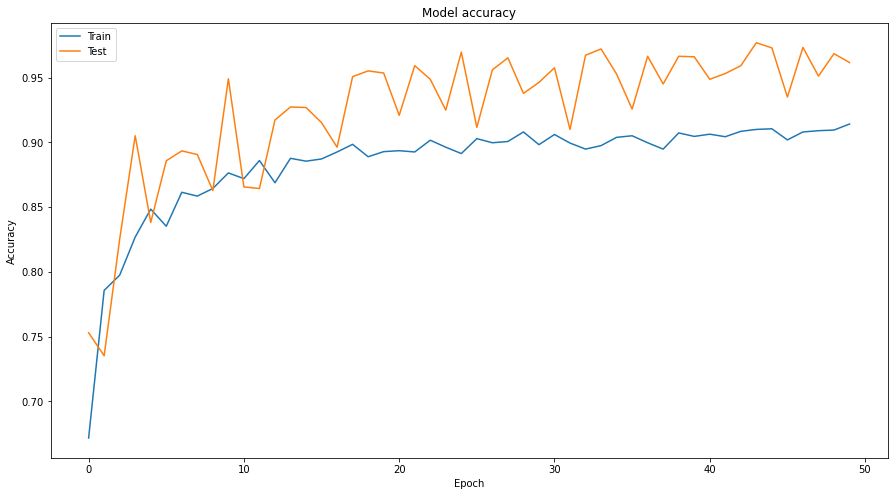

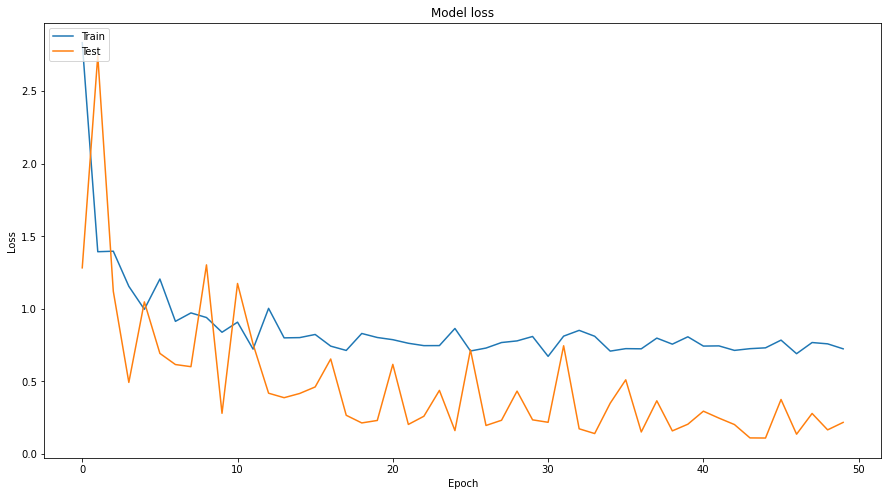

12/12 [==============================] - 13s 726ms/step


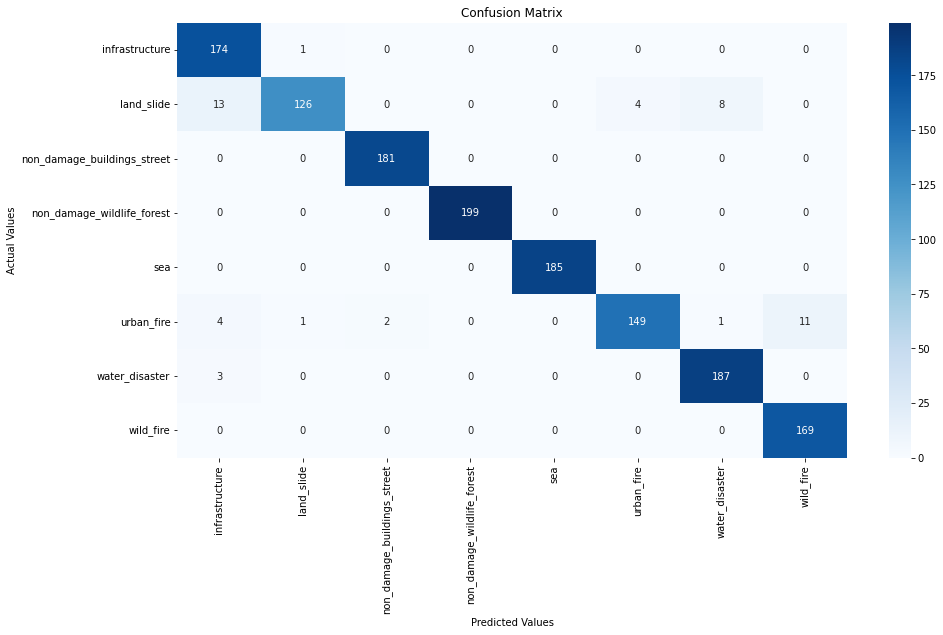

In [17]:
model = build_model(measure_performance=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

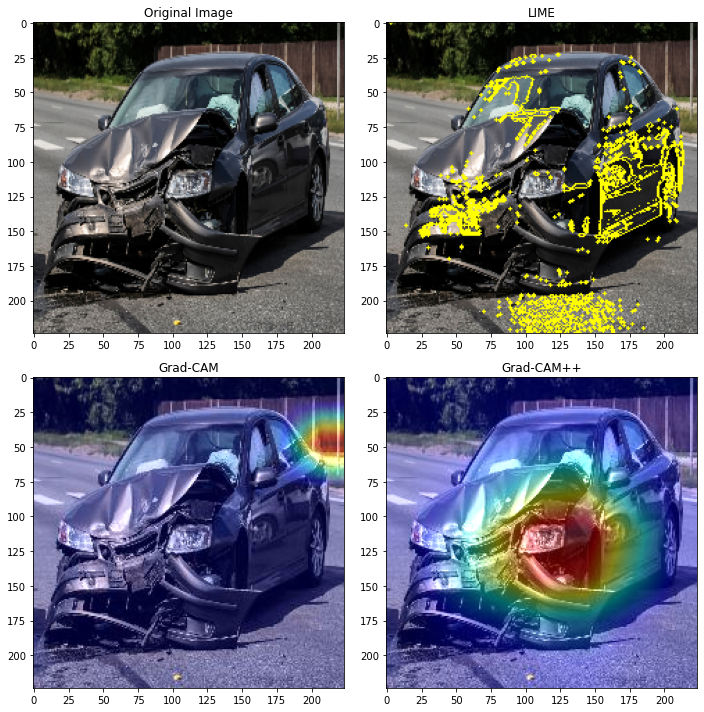

1/1 [==============================] - 1s 1s/step

✓ Model Output ==> infrastructure



In [18]:
img = url_to_image('https://maverickraylaw.com/wp-content/uploads/2021/10/shutterstock_1143680258-1.jpg')
plot_XAI(img, model)
predict_image_class(img, model)

  0%|          | 0/1000 [00:00<?, ?it/s]

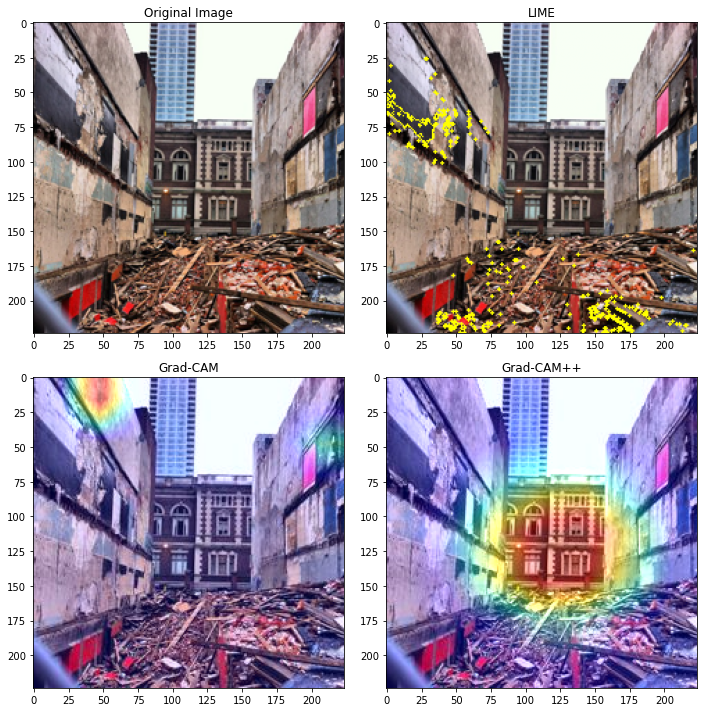

1/1 [==============================] - 0s 31ms/step

✓ Model Output ==> infrastructure



In [19]:
img = path_to_image('infrastructure/05_01_1225.png')
plot_XAI(img, model)
predict_image_class(img, model)

  0%|          | 0/1000 [00:00<?, ?it/s]

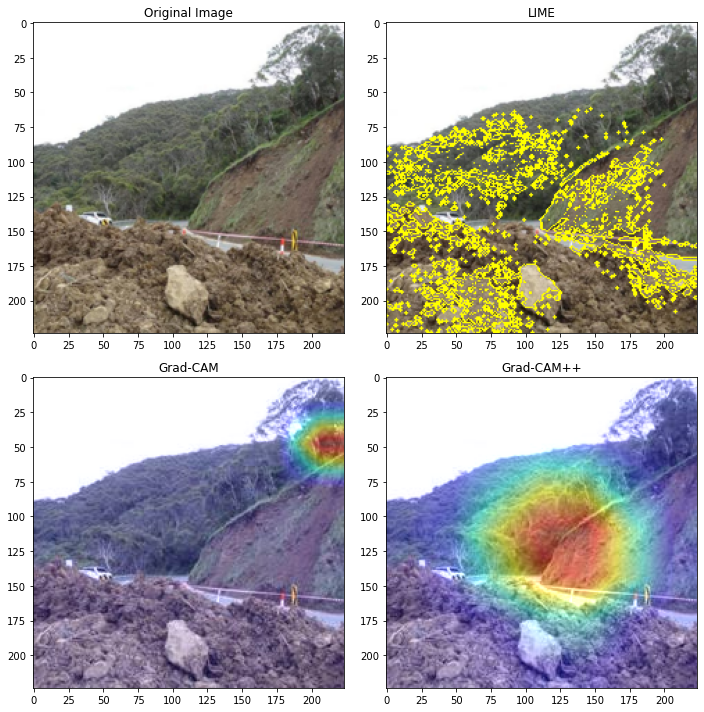

1/1 [==============================] - 0s 28ms/step

✓ Model Output ==> land_slide



In [20]:
img = path_to_image('land_slide/04_01_0005.png')
plot_XAI(img, model)
predict_image_class(img, model)

  0%|          | 0/1000 [00:00<?, ?it/s]

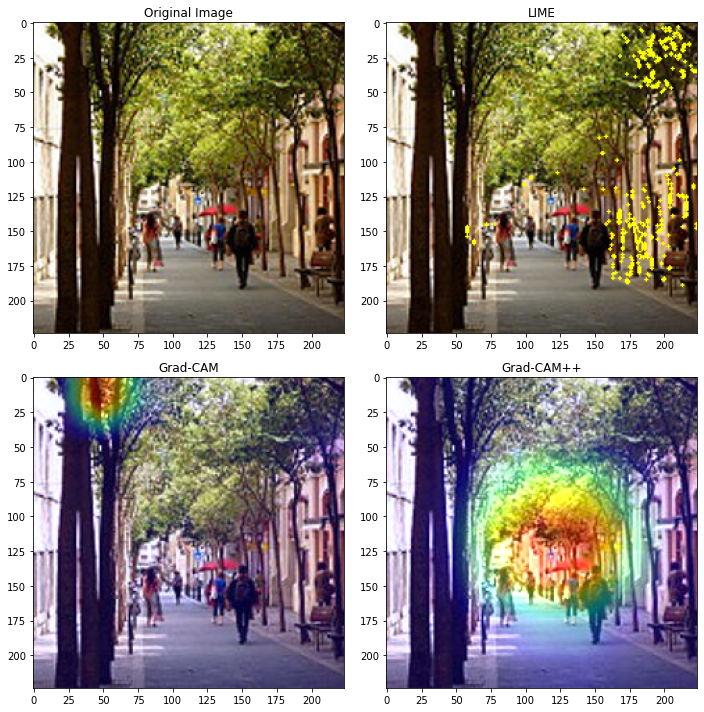

1/1 [==============================] - 0s 29ms/step

✓ Model Output ==> non_damage_buildings_street



In [21]:
img = path_to_image('non_damage_buildings_street/06_02_2615.png')
plot_XAI(img, model)
predict_image_class(img, model)

  0%|          | 0/1000 [00:00<?, ?it/s]

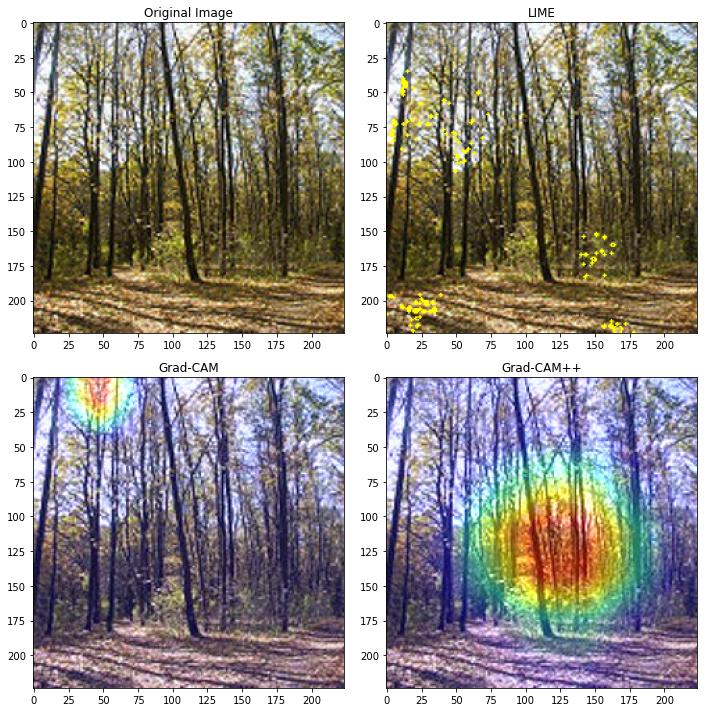

1/1 [==============================] - 0s 33ms/step

✓ Model Output ==> non_damage_wildlife_forest



In [22]:
img = path_to_image('non_damage_wildlife_forest/06_03_1742.png')
plot_XAI(img, model)
predict_image_class(img, model)

  0%|          | 0/1000 [00:00<?, ?it/s]

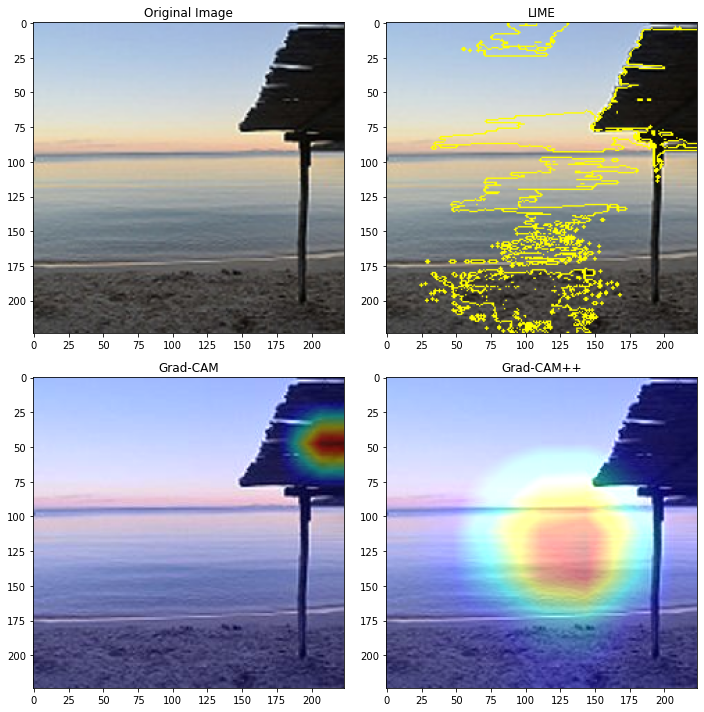

1/1 [==============================] - 0s 32ms/step

✓ Model Output ==> sea



In [23]:
img = path_to_image('sea/06_04_0780.png')
plot_XAI(img, model)
predict_image_class(img, model)

  0%|          | 0/1000 [00:00<?, ?it/s]

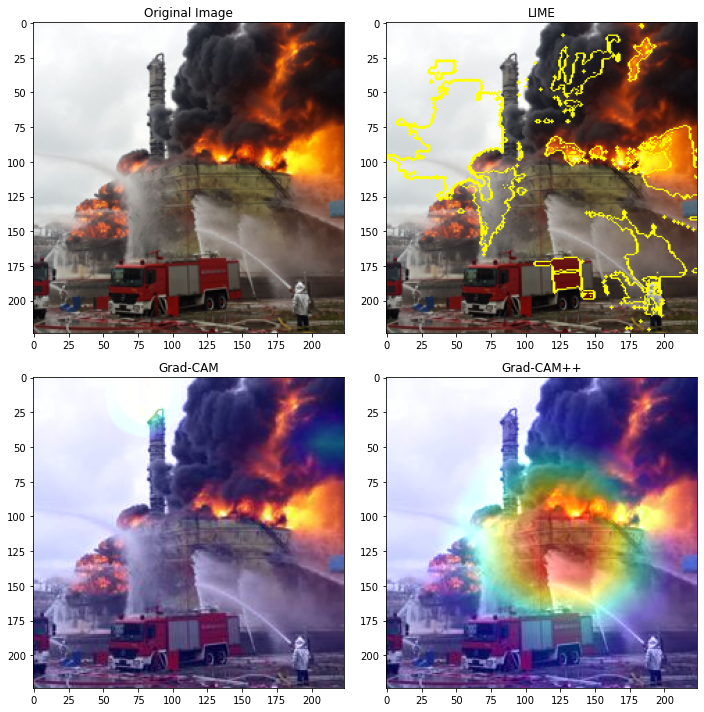

1/1 [==============================] - 0s 27ms/step

✓ Model Output ==> urban_fire



In [24]:
img = path_to_image('urban_fire/01_01_0363.png')
plot_XAI(img, model)
predict_image_class(img, model)

  0%|          | 0/1000 [00:00<?, ?it/s]

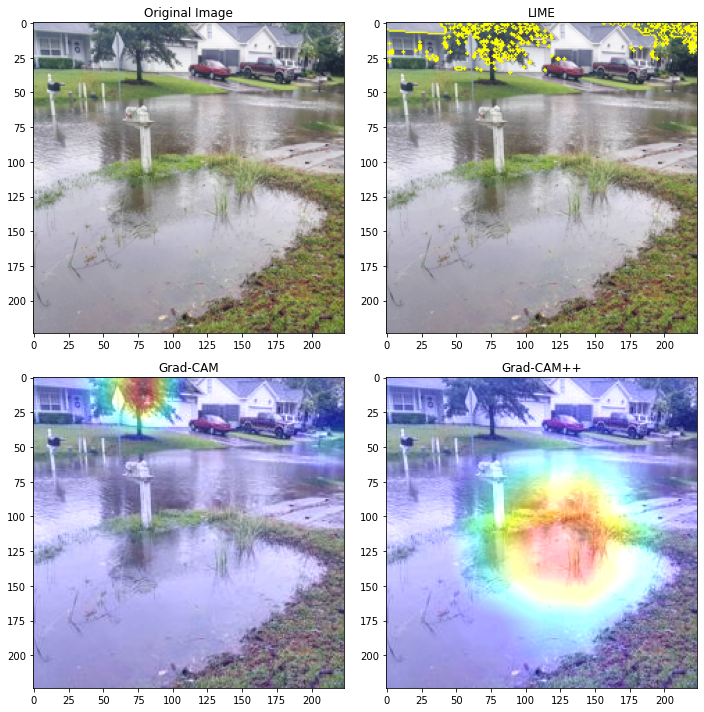

1/1 [==============================] - 0s 27ms/step

✓ Model Output ==> water_disaster



In [25]:
img = path_to_image('water_disaster/03_0005.png')
plot_XAI(img, model)
predict_image_class(img, model)

  0%|          | 0/1000 [00:00<?, ?it/s]

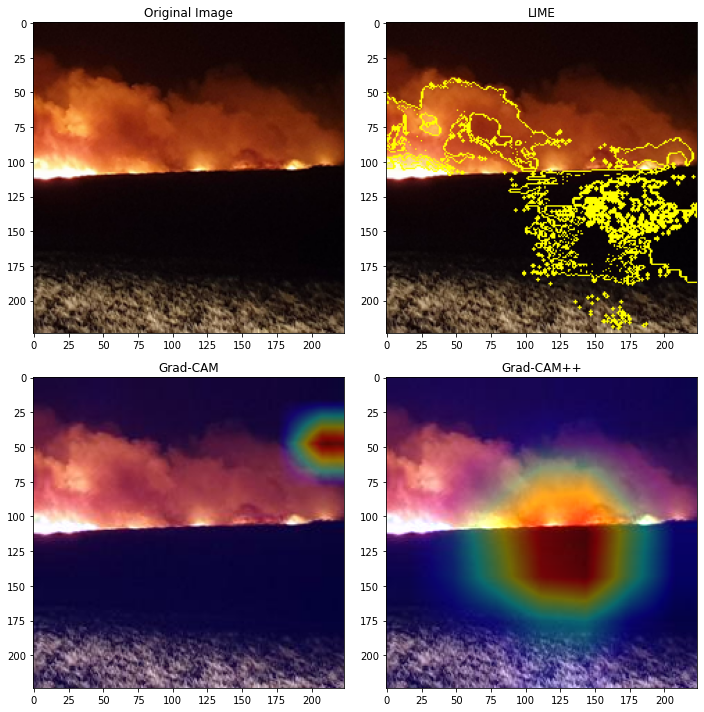

1/1 [==============================] - 0s 27ms/step

✓ Model Output ==> wild_fire



In [26]:
img = path_to_image('wild_fire/01_02_0471.png')
plot_XAI(img, model)
predict_image_class(img, model)